In [1]:
import sys
sys.path.append('..')

In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from CommonFunctions import *
%matplotlib inline

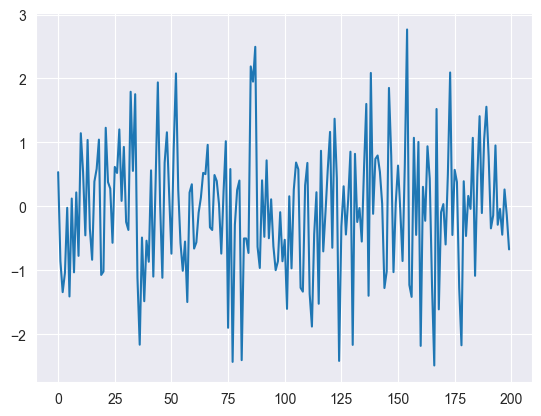

In [9]:
size = 200
sample = np.random.normal(loc=0, scale=1, size=size)
plt.plot(sample)

In [12]:
def moving_average(theta_params, random_array, burning=1):
    number_of_theta = len(theta_params)
    number_of_samples = len(random_array)
    ma_series = np.zeros(number_of_samples - number_of_theta)
    for index in range(number_of_theta, number_of_samples):
        new_value = 0
        for i, theta in enumerate(theta_params):
            new_value += random_array[index - i] * theta
        ma_series[index] = new_value
    return ma_series

In [13]:
thetas = [20, 1, 0.8]
ma = moving_average(thetas, sample)
plt.plot(ma)

IndexError: index 197 is out of bounds for axis 0 with size 197